In [16]:
import os
import vtk
import numpy as np
import matplotlib.pyplot as plt
from utilities import ReadVTIFile, WriteVTPFile
import xml.etree.ElementTree as ET
from scipy.spatial.transform import Rotation as R
from vtk.util.numpy_support import vtk_to_numpy


InputFolder = "/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/FlowVisualization/SU03B/Paths"
g1 = os.path.join(InputFolder,"graft1.pth")
g2 = os.path.join(InputFolder,"graft2.pth")
image = os.path.join(InputFolder, "SU03B.vti")


In [17]:
ImageVTI = ReadVTIFile(image)

In [18]:
def CutPlane(Volume,Origin,Norm):
    plane=vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice=vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    return Slice.GetOutput()

def PlaneClip(volume,center, a):
    box = vtk.vtkBox()
    box.SetBounds(
        center[0] - a, center[0] + a,
        center[1] - a, center[1] + a,
        center[2] - a, center[2] + a
    )

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(volume)
    clipper.SetClipFunction(box)
    clipper.InsideOutOn()
    clipper.GetOutputInformation(1)
    clipper.Update()

    return clipper.GetOutput()

def clip_polydata_with_plane(polydata, origin, normal, inside_out=False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipPolyData()
    clipper.SetInputData(polydata)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

In [19]:
pathline_file = g1

with open(pathline_file, "r") as path:
    #path.readlines()
    tree = ET.parse(path)
root = tree.getroot()

direction_points = []
for direction_point in root.findall(".//path_point/tangent"):
    x = float(direction_point.attrib['x'])
    y = float(direction_point.attrib['y'])
    z = float(direction_point.attrib['z'])
    direction_points.append((x,y,z))

path_points = []
for path_point in root.findall(".//path_point/pos"):
    x = float(path_point.attrib['x'])
    y = float(path_point.attrib['y'])
    z = float(path_point.attrib['z'])
    path_points.append((x,y,z))

path_normals = []
for normal in root.findall(".//path_point/rotation"):
    x = float(normal.attrib['x'])
    y = float(normal.attrib['y'])
    z = float(normal.attrib['z'])
    path_normals.append((x,y,z))

NPoints = len(path_points)
print("the number of points in the centerline is:", NPoints)

binormal = []
for i in range(NPoints):
    binormal_ = np.cross(np.array(direction_points[i]),np.array(path_normals[i]))
    binormal_ /= np.linalg.norm(binormal_)
    binormal.append(binormal_)

the number of points in the centerline is: 113


In [20]:
p = path_points[2]
p_ = path_points[0]
a_ = (((p[0]-p_[0])**2 + (p[1]-p_[1])**2 + (p[2]-p_[2])**2)**0.5)/2

print(a_)

0.021932591874988822


In [21]:
New_Centreline = np.array([-i*a_/2 for i in range(0,(NPoints-1))])
New_Centreline

array([ 0.        , -0.0109663 , -0.02193259, -0.03289889, -0.04386518,
       -0.05483148, -0.06579778, -0.07676407, -0.08773037, -0.09869666,
       -0.10966296, -0.12062926, -0.13159555, -0.14256185, -0.15352814,
       -0.16449444, -0.17546073, -0.18642703, -0.19739333, -0.20835962,
       -0.21932592, -0.23029221, -0.24125851, -0.25222481, -0.2631911 ,
       -0.2741574 , -0.28512369, -0.29608999, -0.30705629, -0.31802258,
       -0.32898888, -0.33995517, -0.35092147, -0.36188777, -0.37285406,
       -0.38382036, -0.39478665, -0.40575295, -0.41671925, -0.42768554,
       -0.43865184, -0.44961813, -0.46058443, -0.47155073, -0.48251702,
       -0.49348332, -0.50444961, -0.51541591, -0.5263822 , -0.5373485 ,
       -0.5483148 , -0.55928109, -0.57024739, -0.58121368, -0.59217998,
       -0.60314628, -0.61411257, -0.62507887, -0.63604516, -0.64701146,
       -0.65797776, -0.66894405, -0.67991035, -0.69087664, -0.70184294,
       -0.71280924, -0.72377553, -0.73474183, -0.74570812, -0.75

In [27]:
def Rotate(slice, normal, direction, ArrayName, centre, new_centre):
    rotation1, _ = R.align_vectors([[0, 1, 0]], [normal])
    rotation2, _ = R.align_vectors([[0, 0, -1]], [direction])

    centre = np.array(centre)
    new_centre = np.array([0, 0, new_centre])
    new_point_x = []
    new_point_y = []
    new_point_z = []
    for i in range(slice.GetNumberOfPoints()):
        point_init = np.array(slice.GetPoint(i))
        point_translated = point_init - centre
        point_rotated = rotation2.apply(rotation1.apply( point_translated))
        point_final = point_rotated + new_centre
        new_point_x.append(point_final[0])
        new_point_y.append(point_final[1])
        new_point_z.append(point_final[2])

    new_point_x = np.array(new_point_x)
    new_point_y = np.array(new_point_y)
    new_point_z = np.array(new_point_z)
    scalar_value = vtk_to_numpy(slice.GetPointData().GetArray(ArrayName))

    return new_point_x, new_point_y, new_point_z, scalar_value

In [28]:
append_filter_npr3d = vtk.vtkAppendPolyData()

a = 10*a_

new_point_x = np.array([])
new_point_y = np.array([])
new_point_z = np.array([])
Scalars = np.array([])
step = 2
for i in range(1, 20, step):
    npr3d_ = CutPlane(PlaneClip(ImageVTI, path_points[i],a), path_points[i], binormal[i])
    npr3d_ = clip_polydata_with_plane(npr3d_,path_points[i-1], direction_points[i])
    npr3d_ = clip_polydata_with_plane(npr3d_,path_points[i+1], direction_points[i], True)
    append_filter_npr3d.AddInputData(npr3d_)

    x_, y_, z_, scalar_ = Rotate(npr3d_, binormal[i], direction_points[i], "Scalars_", path_points[i], New_Centreline[i])
    new_point_x = np.concatenate([x_, new_point_x])
    new_point_y = np.concatenate([y_, new_point_y])
    new_point_z = np.concatenate([z_, new_point_z])
    Scalars = np.concatenate([scalar_, Scalars])
    
append_filter_npr3d.Update()
NPR3D = append_filter_npr3d.GetOutput()

opath = os.path.join(InputFolder, "NPR3D.vtp")
WriteVTPFile(opath, NPR3D)

/var/folders/05/bygg4rdj3n7543jkngl6k6z40000gn/T/ipykernel_17150/1598340847.py:2: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation1, _ = R.align_vectors([[0, 1, 0]], [normal])
/var/folders/05/bygg4rdj3n7543jkngl6k6z40000gn/T/ipykernel_17150/1598340847.py:3: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation2, _ = R.align_vectors([[0, 0, -1]], [direction])


In [36]:
np.array([0,1,0])+np.array([1,0,0])

array([1, 1, 0])

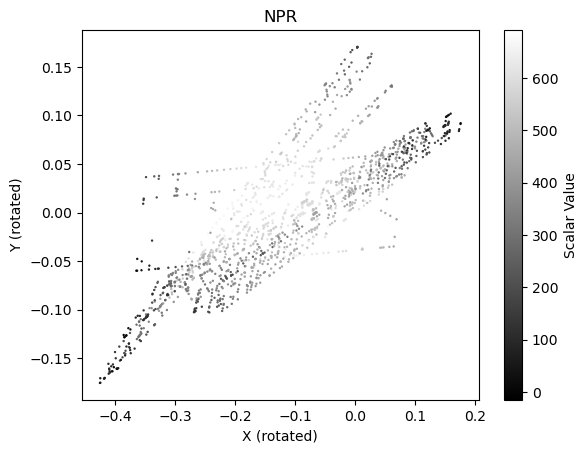

In [38]:
plt.figure()
sc = plt.scatter(new_point_z, new_point_x, c=Scalars, cmap='gray', s=0.5)
plt.colorbar(sc, label='Scalar Value')
#plt.axis('equal')
plt.xlabel('X (rotated)')
plt.ylabel('Y (rotated)')
plt.title('NPR')
plt.show()